<a href="https://colab.research.google.com/github/Tahirkazmi72/Driver-Drowsie-System/blob/master/LOSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install neurokit2 pandas numpy scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 17.5 MB/s eta 0:00:00


In [ ]:
!unzip S8.zip

In [ ]:
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk
import os

# 1. Configuration
# Tamam subjects ki list (S12 missing hota hai WESAD mein)
subjects = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

sampling_rate = 700
window_size = 30 * sampling_rate
master_features = []

print(f"Starting processing for {len(subjects)} subjects...")

# 2. Outer Loop: Subject wise
for sub in subjects:
    file_path = f'{sub}.pkl' # Agar files folder mein hain to 'WESAD/{sub}/{sub}.pkl' likhein

    if not os.path.exists(file_path):
        print(f"⚠️ Warning: {file_path} nahi mili. Skipping...")
        continue

    print(f"--- Processing {sub} ---")

    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')

        ecg = data['signal']['chest']['ECG'].flatten()
        acc = data['signal']['chest']['ACC']
        labels = data['label']

        # 3. Inner Loop: Windowing (30 seconds segments)
        for i in range(0, len(ecg) - window_size, window_size):
            window_ecg = ecg[i : i + window_size]
            window_label = labels[i + (window_size//2)]
            window_acc = acc[i : i + window_size]

            try:
                # Signal Cleaning & Peak Detection
                cleaned_ecg = nk.ecg_clean(window_ecg, sampling_rate=sampling_rate)
                peaks, info = nk.ecg_peaks(cleaned_ecg, sampling_rate=sampling_rate)

                # HRV Features (Time Domain)
                hrv = nk.hrv_time(peaks, sampling_rate=sampling_rate)

                # Accelerometer Magnitude (Motion/Vibration)
                # Formula: sqrt(x^2 + y^2 + z^2)
                acc_mag = np.mean(np.sqrt(np.sum(window_acc**2, axis=1)))

                # --- Multi-Task Labeling Logic ---
                # Stress = 1 if WESAD label is 2
                is_stress = 1 if window_label == 2 else 0

                # Exertion = 1 if vibration is high (Threshold 0.1 as per your logic)
                is_exertion = 1 if (acc_mag > 0.1) else 0

                # Master List mein data save karein
                master_features.append({
                    'Subject_ID': sub,
                    'RMSSD': hrv['HRV_RMSSD'].values[0],
                    'SDNN': hrv['HRV_SDNN'].values[0],
                    'Vibration': acc_mag,
                    'Stress_Label': is_stress,
                    'Exertion_Label': is_exertion
                })
            except Exception as e:
                # Agar kisi window mein signal kharab ho to ignore karein
                continue

    except Exception as e:
        print(f"❌ Error loading {sub}: {e}")

# 4. Final Master DataFrame aur Save
if master_features:
    df_master = pd.DataFrame(master_features)
    df_master.to_csv('Master_TinyML_Dataset.csv', index=False)
    print("\n✅ SUCCESS!")
    print(f"Master CSV Saved: Master_TinyML_Dataset.csv")
    print(f"Total processed windows: {len(df_master)}")
    print(df_master.groupby(['Subject_ID', 'Stress_Label']).size().unstack(fill_value=0))
else:
    print("❌ No data processed.")

Starting processing for 15 subjects...
⚠️ Warning: S2.pkl nahi mili. Skipping...
⚠️ Warning: S3.pkl nahi mili. Skipping...
⚠️ Warning: S4.pkl nahi mili. Skipping...
⚠️ Warning: S5.pkl nahi mili. Skipping...
⚠️ Warning: S6.pkl nahi mili. Skipping...
⚠️ Warning: S7.pkl nahi mili. Skipping...
⚠️ Warning: S8.pkl nahi mili. Skipping...
⚠️ Warning: S9.pkl nahi mili. Skipping...
⚠️ Warning: S10.pkl nahi mili. Skipping...
⚠️ Warning: S11.pkl nahi mili. Skipping...
⚠️ Warning: S13.pkl nahi mili. Skipping...
⚠️ Warning: S14.pkl nahi mili. Skipping...
⚠️ Warning: S15.pkl nahi mili. Skipping...
⚠️ Warning: S16.pkl nahi mili. Skipping...
⚠️ Warning: S17.pkl nahi mili. Skipping...
❌ No data processed.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# ======================================================
# 0. LOAD DATA
# ======================================================
df = pd.read_csv("Master_TinyML_Dataset.csv")

df = df.rename(columns={"Subject_ID": "subject"})
assert {'subject','RMSSD','SDNN','Vibration','Stress_Label'}.issubset(df.columns)

# ======================================================
# 1. ADAPTIVE EXERTION LABEL (SUBJECT BASELINE)
# ======================================================
vib_th = df['Vibration'].quantile(0.75)

baseline_rmssd = df.groupby("subject")["RMSSD"].transform("median")
delta_rmssd = baseline_rmssd - df["RMSSD"]

df["Exertion_Label"] = ((delta_rmssd > delta_rmssd.quantile(0.6)) &
                        (df["Vibration"] > vib_th)).astype(int)

# ======================================================
# 2. WINDOWING WITH STRIDE + MAJORITY VOTING
# ======================================================
FEATURES = ["RMSSD","SDNN","Vibration"]
TIME_STEPS = 10
STRIDE = 5

def create_windows(df_sub):
    X = df_sub[FEATURES].values
    ys = df_sub["Stress_Label"].values
    ye = df_sub["Exertion_Label"].values

    Xw, ysw, yew = [], [], []
    for i in range(0, len(X)-TIME_STEPS, STRIDE):
        Xw.append(X[i:i+TIME_STEPS])
        ysw.append(int(np.round(np.mean(ys[i:i+TIME_STEPS]))))
        yew.append(int(np.round(np.mean(ye[i:i+TIME_STEPS]))))

    return np.array(Xw), np.array(ysw), np.array(yew)

# ======================================================
# 3. MODEL (REGULARIZED + TINYML SAFE)
# ======================================================
def build_model():
    inp = layers.Input(shape=(TIME_STEPS,3))

    x = layers.Bidirectional(
        layers.GRU(32, return_sequences=True,
                   dropout=0.3, recurrent_dropout=0.1,
                   kernel_regularizer=regularizers.l2(1e-4))
    )(inp)

    att = layers.Dense(1, activation='tanh')(x)
    att = layers.Softmax(axis=1)(att)
    x = layers.Multiply()([x, att])
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(32, activation='relu')(x)

    stress = layers.Dense(1, activation='sigmoid', name="stress")(x)
    exert  = layers.Dense(1, activation='sigmoid', name="exert")(x)

    model = models.Model(inp, [stress, exert])
    return model

# ======================================================
# 4. LOSO EVALUATION
# ======================================================
subjects = sorted(df.subject.unique())
results = []

for test_sub in subjects:
    train_df = df[df.subject != test_sub].copy()
    test_df  = df[df.subject == test_sub].copy()

    # ---- scaling (train only) ----
    scaler = StandardScaler()
    train_df[FEATURES] = scaler.fit_transform(train_df[FEATURES])
    test_df[FEATURES]  = scaler.transform(test_df[FEATURES])

    # ---- windowing ----
    Xtr, ys_tr, ye_tr = [], [], []
    for _, g in train_df.groupby("subject"):
        Xw, ysw, yew = create_windows(g)
        if len(Xw) > 0:
            Xtr.append(Xw)
            ys_tr.append(ysw)
            ye_tr.append(yew)

    Xtr = np.concatenate(Xtr)
    ys_tr = np.concatenate(ys_tr)
    ye_tr = np.concatenate(ye_tr)

    Xte, ys_te, ye_te = create_windows(test_df)
    if len(Xte) == 0:
        continue

    # ---- sample weighting instead of SMOTE ----
    stress_w = np.where(ys_tr == 1, 2.0, 1.0)
    exert_w  = np.where(ye_tr == 1, 1.2, 1.0)

    # ---- train ----
    model = build_model()
    model.compile(
        optimizer=optimizers.Adam(0.001),
        loss={"stress":"binary_crossentropy",
              "exert":"binary_crossentropy"},
        loss_weights={"stress":1.5,"exert":0.8}
    )

    model.fit(
        Xtr,
        [ys_tr, ye_tr], # Changed this from dictionary to list
        sample_weight=[stress_w, exert_w], # Changed this from dictionary to list
        epochs=40,
        batch_size=32,
        verbose=0
    )

    # ---- test ----
    preds = model(Xte, training=False)
    s_pred = (preds[0].numpy() > 0.5).astype(int).flatten()
    e_pred = (preds[1].numpy() > 0.5).astype(int).flatten()

    stress_acc = np.mean(s_pred == ys_te) * 100
    exert_acc  = np.mean(e_pred == ye_te) * 100
    joint_acc  = np.mean((s_pred == ys_te) & (e_pred == ye_te)) * 100

    results.append([test_sub, stress_acc, exert_acc, joint_acc])

# ======================================================
# 5. FINAL REPORT
# ======================================================
res = pd.DataFrame(results,
                   columns=["subject","stress_acc","exert_acc","joint_acc"])

print(res)
print("\nMEAN PERFORMANCE:")
print(res[["stress_acc","exert_acc","joint_acc"]].mean())

print("\nWORST SUBJECTS:")
print(res.sort_values("joint_acc").head(3))


   subject  stress_acc   exert_acc  joint_acc
0      S10   80.000000  100.000000  80.000000
1      S11   84.848485  100.000000  84.848485
2      S13   85.714286  100.000000  85.714286
3      S14   68.571429  100.000000  68.571429
4      S15   84.848485  100.000000  84.848485
5      S16   88.888889  100.000000  88.888889
6      S17   86.842105   86.842105  86.842105
7       S2   89.743590   97.435897  87.179487
8       S3   90.476190  100.000000  90.476190
9       S4   90.243902   95.121951  85.365854
10      S5   90.000000  100.000000  90.000000
11      S6   91.111111   93.333333  84.444444
12      S7   87.878788  100.000000  87.878788
13      S8   88.571429   85.714286  74.285714
14      S9   87.878788   96.969697  84.848485

MEAN PERFORMANCE:
stress_acc    86.374498
exert_acc     97.027818
joint_acc     84.279509
dtype: float64

WORST SUBJECTS:
   subject  stress_acc   exert_acc  joint_acc
3      S14   68.571429  100.000000  68.571429
13      S8   88.571429   85.714286  74.285714
0  

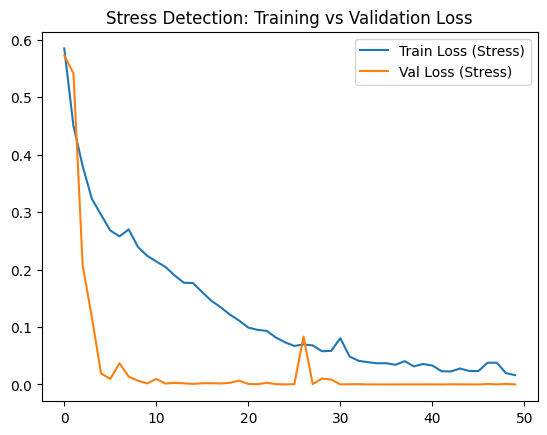

In [ ]:
import matplotlib.pyplot as plt

# Stress Output ka loss check karein
plt.plot(history.history['stress_output_loss'], label='Train Loss (Stress)')
plt.plot(history.history['val_stress_output_loss'], label='Val Loss (Stress)')
plt.title('Stress Detection: Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf

# 1. Keras model ko TFLite format mein convert karein
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 2. Optimization (Quantization) - Q1 Paper ki jaan hai ye step
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# FIX: Address the ConverterError for GRU layers and TensorList operations
# Allow selective TensorFlow ops and disable experimental lowering of tensor list ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

# 3. Convert
tflite_model = converter.convert()

# 4. Save the model
with open('rider_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ SUCCESS: model.tflite tayyar hai!")

# Size check karein
import os
size_kb = os.path.getsize('rider_model.tflite') / 1024
print(f"Model Size: {size_kb:.2f} KB")

Saved artifact at '/tmp/tmpl0r7pff1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 3), dtype=tf.float32, name='keras_tensor_477')
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  135414825765200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414977109968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414825766160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414935445264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414935445648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414935453328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414977116496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414977108240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414825766352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414825767696: Tenso

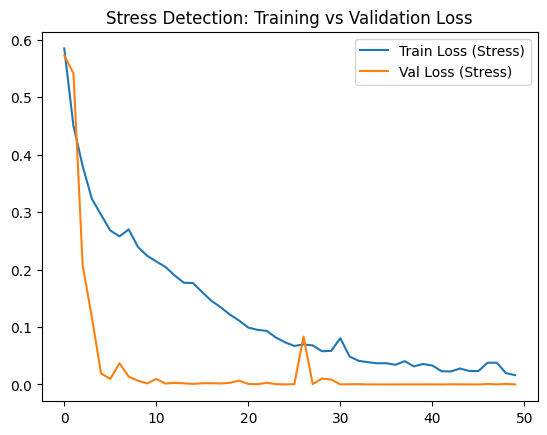

In [ ]:
import matplotlib.pyplot as plt

# Stress Output ka loss check karein
plt.plot(history.history['stress_output_loss'], label='Train Loss (Stress)')
plt.plot(history.history['val_stress_output_loss'], label='Val Loss (Stress)')
plt.title('Stress Detection: Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf

# 1. Keras model ko TFLite format mein convert karein
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 2. Optimization (Quantization) - Q1 Paper ki jaan hai ye step
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# FIX: Address the ConverterError for GRU layers and TensorList operations
# Allow selective TensorFlow ops and disable experimental lowering of tensor list ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

# 3. Convert
tflite_model = converter.convert()

# 4. Save the model
with open('rider_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ SUCCESS: model.tflite tayyar hai!")

# Size check karein
import os
size_kb = os.path.getsize('rider_model.tflite') / 1024
print(f"Model Size: {size_kb:.2f} KB")

Saved artifact at '/tmp/tmpo1gzms21'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 3), dtype=tf.float32, name='keras_tensor_477')
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  135414825765200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414977109968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414825766160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414935445264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414935445648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414935453328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414977116496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414977108240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414825766352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135414825767696: Tenso

In [ ]:
# Linux command 'xxd' use karke model ko C++ header mein badlein
!apt-get update && apt-get install xxd
!xxd -i rider_model.tflite > rider_model_data.h

print("✅ SUCCESS: rider_model_data.h tayyar hai!")
print("Ab aap is file ko download karke Arduino ya ESP32 ke project mein shamil kar sakte hain.")

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 388 kB in 1s (278 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xxd is already the newest

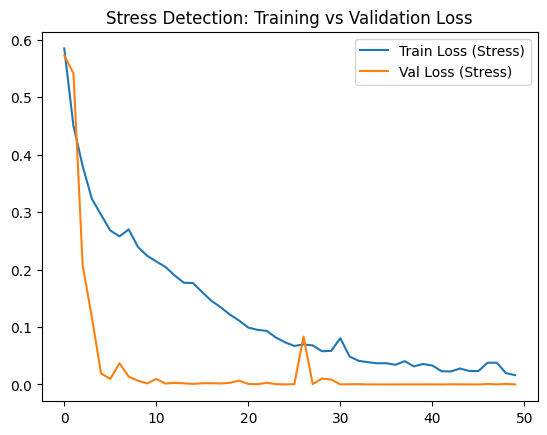

In [ ]:
import matplotlib.pyplot as plt

# Stress Output ka loss check karein
plt.plot(history.history['stress_output_loss'], label='Train Loss (Stress)')
plt.plot(history.history['val_stress_output_loss'], label='Val Loss (Stress)')
plt.title('Stress Detection: Training vs Validation Loss')
plt.legend()
plt.show()